In [1]:
#imports and functions - run me

import sys
sys.path.append('/dls_sw/apps/scisoftpy/2.7')
sys.path.append('/dls_sw/i16/software/python')
from dlstools.dataloader import *
from dlstools import *
from matplotlib.pyplot import *

from dlstools.tictoc import tictoc
tt = tictoc()

out_folder = '/dls/science/users/spc93/pdc/'
close('all')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
pd.set_option('display.max_rows',18)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

%matplotlib notebook 

def get_files_and_start_times(path,labelstr):
    
    #debug code -delete
    print path, labelstr
    ###################
    
    files=[]; times=[]
    file_list=os.listdir(path); file_list.sort();
    for file in file_list:
        firstline=pd.read_csv(path+file, sep='\t', usecols=[0,1,2,3], names=['I','J','ToA','ToT'], nrows=1)
        try:
            times+=[firstline.ToA[0]]
            files+=[file]
        except:
            print "no data: File:", file
    
    df=pd.DataFrame({'files'+labelstr:files, 'ToA'+labelstr:times})
    df['sec'+labelstr]=df['ToA'+labelstr]*2e-9;    df['mins'+labelstr]=df['sec'+labelstr]/60.0;    df['hours'+labelstr]=df['mins'+labelstr]/60.0;
    return df
   
def get_all_file_pairs_old(path_top, path_bot):      
    top_files_times=get_files_and_start_times(path_top,'0')
    bot_files_times=get_files_and_start_times(path_bot,'1')
    all=top_files_times.join(bot_files_times)
    all['ToA_offset']=all.ToA1-all.ToA0
    all['TimeOffsetSec']=all['ToA_offset']*2e-9
    return all


def get_all_file_pairs(path_top, path_bot):      
    top_files_times=get_files_and_start_times(path_top,'0')
    bot_files_times=get_files_and_start_times(path_bot,'1')
    bot_files_times_aligned=bot_files_times.copy()
    for ii in range(len(top_files_times)):
        sec0=top_files_times['sec0'][ii]
        idx=np.abs(bot_files_times.sec1-sec0).idxmin() #find index of closest start time of bot to top
        bot_files_times_aligned.loc[ii] = bot_files_times.loc[idx]
    all=top_files_times.join(bot_files_times_aligned)
    all['ToA_offset']=all.ToA1-all.ToA0
    all['TimeOffsetSec']=all['ToA_offset']*2e-9
    return all


def find_coincidences_old(path_top, path_bot, file_pair_table, file_num_list, coinc_time, coinc_range):
    #coinc_time=10   #count as coincidence if within this value
    #coinc_range=50  #plot range for time histograms
    num_events=0
    num_coinc=0
    for filepairnum in file_num_list:
        print "=== Starting file pair %i" % filepairnum
        t=pd.read_csv(path_top+file_pair_table.files0[filepairnum], sep='\t', usecols=[0,1,2,3], names=['I','J','ToA','ToT'])
        b=pd.read_csv(path_bot+file_pair_table.files1[filepairnum], sep='\t', usecols=[0,1,2,3], names=['I','J','ToA','ToT'])
        t['Module']=0; b['Module']=1
        b.I, b.J=255-b.I, 255*2-b.J
        tb=pd.concat([t,b]) #joint modules to make one big detector
        tb.sort_values('ToA',inplace=True)
        tb.ToA=tb.ToA-tb.ToA.min()
        tb['Tdiff']=tb.ToA-tb.ToA.shift(1)
        tb['Mdiff']=tb.Module-tb.Module.shift(1)
        tb['TdiffM']=tb.Tdiff/tb.Mdiff             #ToA difference: +ve if 0 first then 1; -ve if 1 then 0, inf if same module
        coinc_events_range=abs(tb.TdiffM)<=coinc_range #events within coinc_range (for plot)
        tb_coinc_range=tb[coinc_events_range]
        tb_coinc_range.plot(y='TdiffM',kind='hist',bins=1+2*coinc_range, title='Pair No. '+str(filepairnum) ) #will crash if no coincidences
        coinc_events=abs(tb.TdiffM)<=coinc_time #events within coinc_time (for coincidence data)
        tb_coinc=tb[coinc_events]
        tb_coinc_previous=tb.shift(1)[coinc_events]
        del tb_coinc_previous['Tdiff']; del tb_coinc_previous['Mdiff']; del tb_coinc_previous['TdiffM']; 
        tb_coinc_previous.rename(columns={'I':'I0','J':'J0','ToA':'ToA0','ToT':'ToT0','Module':'Module0'}, inplace=True)
        tb_both=tb_coinc.join(tb_coinc_previous)
        if num_events==0:
            all_coinc=tb_both.copy(deep=True)
        else:
            all_coinc=all_coinc.append(tb_both)
        num_events+=len(t)+len(b)
        num_coinc+=len(tb_both)
    all_coinc.reset_index()
    print "===Total events : %i\tCoincidence : %i\t Percentage of coincidences: %.3f" % (num_events, num_coinc, num_coinc*100./num_events)       
    return all_coinc.astype(int)



def find_coincidences(path_top, path_bot, file_pair_table, file_num_list, coinc_time, coinc_range, remove_adjacent=True, plot_histogram=False):
    #coinc_time=10   #count as coincidence if within this value
    #coinc_range=50  #plot range for time histograms
    #remove_adjacent: remove if there is a coincidence with the previous or next event (attempt at removing charge-sharing)
    #plot_histogram: plot coincidences as histogram (slow!)
    
    num_events=0
    num_coinc=0
    for filepairnum in file_num_list:
        print "=== Starting file pair %i" % filepairnum
        t=pd.read_csv(path_top+file_pair_table.files0[filepairnum], sep='\t', usecols=[0,1,2,3], names=['I','J','ToA','ToT'])
        b=pd.read_csv(path_bot+file_pair_table.files1[filepairnum], sep='\t', usecols=[0,1,2,3], names=['I','J','ToA','ToT'])
        t['Module']=0; b['Module']=1
        b.I, b.J=255-b.I, 255*2-b.J
        tb=pd.concat([t,b]) #joint modules to make one big detector
        tb.sort_values('ToA',inplace=True)
        tb.ToA=tb.ToA-tb.ToA.min()
        tb['Tdiff']=tb.ToA-tb.ToA.shift(1)
        tb['Mdiff']=tb.Module-tb.Module.shift(1)
        tb['TdiffM']=tb.Tdiff/tb.Mdiff             #ToA difference: +ve if 0 first then 1; -ve if 1 then 0, inf if same module
        tb['Prev_coinc']=abs(tb.ToA-tb.ToA.shift(2))<=coinc_range
        tb['Next_coinc']=abs(tb.ToA-tb.ToA.shift(-1))<=coinc_range
        coinc_events_range=abs(tb.TdiffM)<=coinc_range #events within coinc_range (for plot)
        tb_coinc_range=tb[coinc_events_range]
        if plot_histogram:
            tb_coinc_range.plot(y='TdiffM',kind='hist',bins=1+2*coinc_range, title='Pair No. '+str(filepairnum) ) #will crash if no coincidences
        if remove_adjacent: #coincidences are events between different modules where no coicidence in adjacent events
            #coinc_events=abs(tb.TdiffM)<=coinc_time & ~tb['Prev_coinc'] & ~tb['Next_coinc']
            coinc_events = (abs(tb.TdiffM)<=coinc_time) & (tb['Prev_coinc']==False) & (tb['Next_coinc']==False)
            #tb['BeTrue'] = (abs(tb.TdiffM)<=coinc_time) & (tb['Prev_coinc']==False) & (tb['Next_coinc']==False)
        else: #coincidences are events between different modules 
            coinc_events=abs(tb.TdiffM)<=coinc_time #events within coinc_time (for coincidence data)
        
        tb_coinc=tb[coinc_events]
        print '=== No. coinc. events:', len(tb_coinc)
        tb_coinc_previous=tb.shift(1)[coinc_events]
        del tb_coinc_previous['Tdiff']; del tb_coinc_previous['Mdiff']; del tb_coinc_previous['TdiffM']; 
        del tb_coinc_previous['Prev_coinc']; del tb_coinc_previous['Next_coinc']; 
        #del tb_coinc_previous['BeTrue'];

        tb_coinc_previous.rename(columns={'I':'I0','J':'J0','ToA':'ToA0','ToT':'ToT0','Module':'Module0'}, inplace=True)

        #print tb_coinc
        #print tb_coinc_previous
        
        tb_both=tb_coinc.join(tb_coinc_previous)
        if num_events==0:
            all_coinc=tb_both.copy(deep=True)
        else:
            all_coinc=all_coinc.append(tb_both)
        num_events+=len(t)+len(b)
        num_coinc+=len(tb_both)
    all_coinc.reset_index()
    print "===Total events : %i\tCoincidence : %i\t Percentage of coincidences: %.3f" % (num_events, num_coinc, num_coinc*100./num_events)       
    return all_coinc.astype(int)
    #return tb ######## test


def sequential_roi_list(isize, jsize, idivisions, jdivisions):
    iwidth, jwidth=isize/idivisions, jsize/jdivisions 
    roilist=[]
    for ni in range(idivisions):
        for nj in range(jdivisions):  
            roilist+=[[[ni*iwidth,(ni+1)*iwidth-1],[nj*jwidth,(nj+1)*jwidth-1]]]
    return roilist
    
def mk_image1(event_table, isize, jsize):
    mtot=np.zeros([isize, jsize])
    for i in range(len(event_table)):
        mtot[event_table.I.iloc[i], event_table.J.iloc[i]]+=1   #event in roi
        mtot[event_table.I0.iloc[i], event_table.J0.iloc[i]]+=1 #event in coincidence
    return mtot


=== Importing dlstools package


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/dls_sw/apps/scisoftpy/2.7/scisoftpy/_external/tifffile.py:284: UserWarning: ImportError: No module named '_tifffile'. Loading of some compressed images will be very slow. Tifffile.c can be obtained at http://www.lfd.uci.edu/~gohlke/
  "ImportError: No module named '_tifffile'. "
Could not import plotting routines
No module named py4j.java_gateway


=== Need to obtain specfilewrapper.py and compatible specfile.so from ERSF PyMCA package in order to load spec files


In [2]:
#settings for 05/05/17 data

min_entries=1000000 #files with fewer entries (photons) not used

#datadict={'all':range(1,3760)}
datadict={'all':range(2,10)}
dataset='all'
datapath='/dls/i16/data/2017/mt16227-1/processing/5_5_2017/'

#datafolder_top='/20170505_PDC_Top_Decoded/'
#datafolder_bot='/20170505_PDC_Bottom_Decoded/'

datafolder_top='/tmp_top/'
datafolder_bot='/tmp_bot/'



Sun Dec  2 09:40:08 2018 Elapsed time: 222747.60094
/dls/i16/data/2017/mt16227-1/processing/5_5_2017//tmp_top/ 0
/dls/i16/data/2017/mt16227-1/processing/5_5_2017//tmp_bot/ 1


<IPython.core.display.Javascript object>


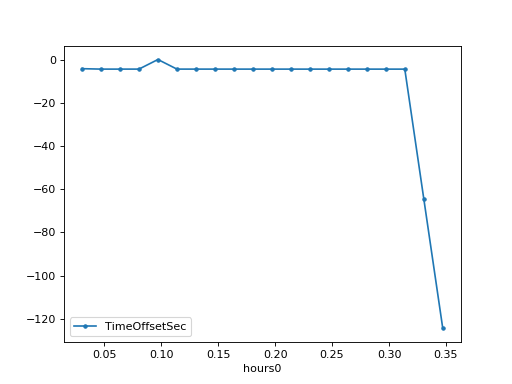

Sun Dec  2 09:40:09 2018 Elapsed time: 222748.436948
=== Starting file pair 2
=== No. coinc. events: 24474
=== Starting file pair 3
=== No. coinc. events: 24169
=== Starting file pair 4
=== No. coinc. events: 3562451
=== Starting file pair 5
=== No. coinc. events: 24295
=== Starting file pair 6
=== No. coinc. events: 24119
=== Starting file pair 7
=== No. coinc. events: 23879
=== Starting file pair 8
=== No. coinc. events: 24482
=== Starting file pair 9
=== No. coinc. events: 24885
===Total events : 256766669	Coincidence : 3732830	 Percentage of coincidences: 1.454
Sun Dec  2 09:46:14 2018 Elapsed time: 223113.220391


In [13]:
#processing 05/05/17 data

#find coincidences and save to hdf5 - do this once only
# get files corresponding to simultaneous pairs. Write to spreadsheet
print tt
allfiles=get_all_file_pairs(datapath+datafolder_top, datapath+datafolder_bot)
allfiles.plot('hours0','TimeOffsetSec',  marker='.' ); axis('tight')
plt.savefig(out_folder+'plot1.pdf')
writer=pd.ExcelWriter(out_folder+'allfiles.xlsx')
allfiles.to_excel(writer)
writer.save()

print tt
#all_coinc=find_coincidences(datapath+datafolder_top, datapath+datafolder_bot, allfiles, datadict[dataset][0:8], 10, 50, 
#                            remove_adjacent=True, plot_histogram=False)
all_coinc=find_coincidences(datapath+datafolder_top, datapath+datafolder_bot, allfiles, datadict[dataset], 10, 50, 
                            remove_adjacent=True, plot_histogram=False)
store = pd.HDFStore(datapath+'/'+dataset+'.h5')
store['all_coinc']=all_coinc
store.close()
print tt


<IPython.core.display.Javascript object>


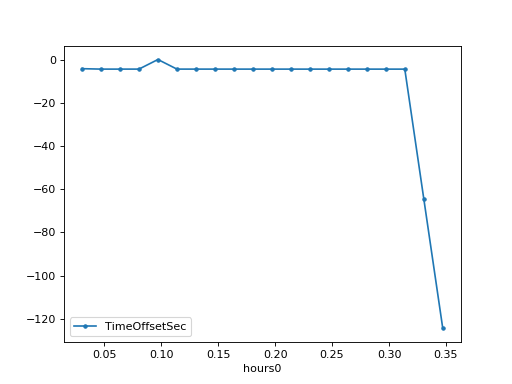

<IPython.core.display.Javascript object>


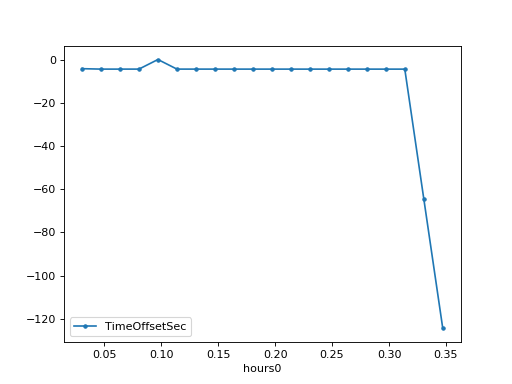

,ToA0,files0,sec0,mins0,hours0,ToA1,files1,sec1,mins1,hours1,ToA_offset,TimeOffsetSec
0,54974048949,W2J2_data_2017-05-05-18-22-21.016819_Newdecode...,109.948098,1.832468,0.030541,52854182246,W5I6_data_2017-05-05-18-22-16.536858_Newdecode...,105.708364,1.761806,0.029363,-2119866703,-4.239733
1,84915625608,W2J2_data_2017-05-05-18-23-21.014819_Newdecode...,169.831251,2.830521,0.047175,82695156646,W5I6_data_2017-05-05-18-23-16.531858_Newdecode...,165.390313,2.756505,0.045942,-2220468962,-4.440938
2,114916007363,W2J2_data_2017-05-05-18-24-21.017818_Newdecode...,229.832015,3.830534,0.063842,112694466918,W5I6_data_2017-05-05-18-24-16.527858_Newdecode...,225.388934,3.756482,0.062608,-2221540445,-4.443081
3,144916380424,W2J2_data_2017-05-05-18-25-21.020818_Newdecode...,289.832761,4.830546,0.080509,142698520874,W5I6_data_2017-05-05-18-25-16.533858_Newdecode...,285.397042,4.756617,0.079277,-2217859550,-4.435719
4,174916246618,W2J2_data_2017-05-05-18-26-21.022818_Newdecode...,349.832493,5.830542,0.097176,174916246618,W2J2_data_2017-05-05-18-26-21.022818_Newdecode...,349.832493,5.830542,0.097176,0,0.000000
5,204917123885,W2J2_data_2017-05-05-18-27-21.026817_Newdecode...,409.834248,6.830571,0.113843,202698064681,W5I6_data_2017-05-05-18-27-16.526858_Newdecode...,405.396129,6.756602,0.112610,-2219059204,-4.438118
6,234917543064,W2J2_data_2017-05-05-18-28-21.029817_Newdecode...,469.835086,7.830585,0.130510,232697405954,W5I6_data_2017-05-05-18-28-16.522858_Newdecode...,465.394812,7.756580,0.129276,-2220137110,-4.440274
7,264917944695,W2J2_data_2017-05-05-18-29-21.026132_Newdecode...,529.835889,8.830598,0.147177,262697579743,W5I6_data_2017-05-05-18-29-16.520858_Newdecode...,525.395159,8.756586,0.145943,-2220364952,-4.440730
8,294918284810,W2J2_data_2017-05-05-18-30-21.017133_Newdecode...,589.836570,9.830609,0.163843,292697195815,W5I6_data_2017-05-05-18-30-16.521398_Newdecode...,585.394392,9.756573,0.162610,-2221088995,-4.442178
...,...,...,...,...,...,...,...,...,...,...,...,...


In [14]:
allfiles.plot('hours0','TimeOffsetSec',  marker='.' ); axis('tight')
allfiles.plot('hours0','TimeOffsetSec',  marker='.' ); axis('tight')
allfiles

Thu Nov 29 19:54:34 2018 Elapsed time: 412.902050018
/dls/i16/data/2017/mt16227-1/processing/5_5_2017//tmp_top/ 0
/dls/i16/data/2017/mt16227-1/processing/5_5_2017//tmp_bot/ 1


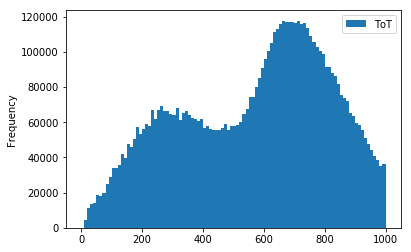

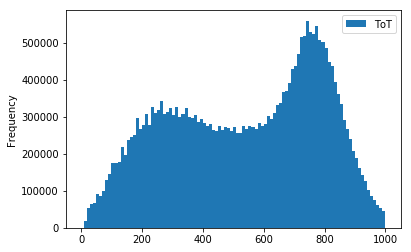

In [5]:
#processing 
#energy spec
print tt
allfiles=get_all_file_pairs(datapath+datafolder_top, datapath+datafolder_bot)
file0 = allfiles['files0'][datadict[dataset][0]]    #    use just first file selected from file pairs
file1 = allfiles['files1'][datadict[dataset][0]]
# takes over 200 sec so comment out
t=pd.read_csv(datapath+datafolder_top+file0, sep='\t', usecols=[0,1,2,3], names=['I','J','ToA','ToT'])
b=pd.read_csv(datapath+datafolder_bot+file1, sep='\t', usecols=[0,1,2,3], names=['I','J','ToA','ToT'])
t.plot(y='ToT',kind='hist', bins=range(0,1001,10))
b.plot(y='ToT',kind='hist', bins=range(0,1001,10))
#bad low-energy tail. top has worse energy resolution
#approx. chans for both: main 300-600; half 150-300
#top fwhm 360-540
#bot fwhm 340-440
#sum of two should be around 350-490

In [6]:
#analyse coincidence data from h5 
#### run first cell first
print tt
store = pd.HDFStore(datapath+'/'+dataset+'.h5')
all_coinc=store['all_coinc']; #load it back
isize=max(all_coinc.I+1)
jsize=max(all_coinc.J+1)



Thu Nov 29 20:04:05 2018 Elapsed time: 984.790642977


Thu Nov 29 20:05:29 2018 Elapsed time: 1068.38915682
Thu Nov 29 20:06:31 2018 Elapsed time: 1130.59968495


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Thu Nov 29 20:08:43 2018 Elapsed time: 1262.81072879


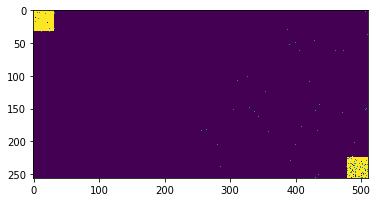

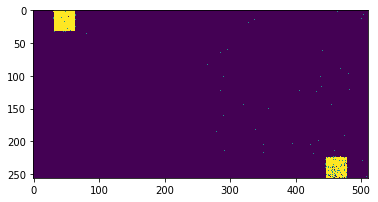

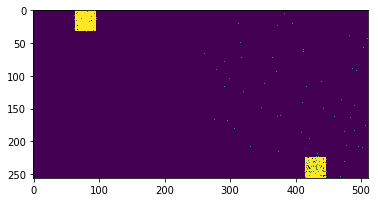

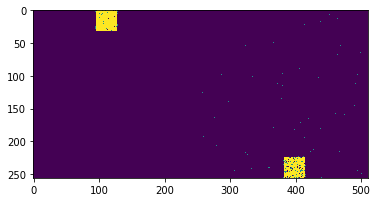

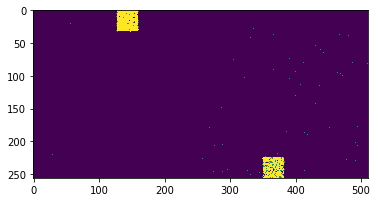

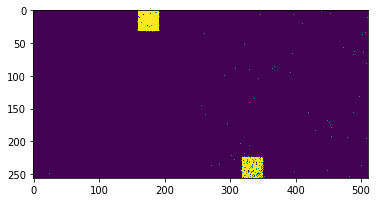

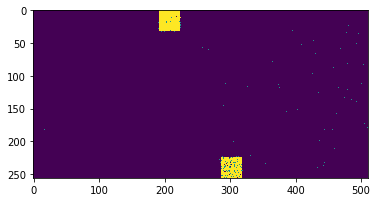

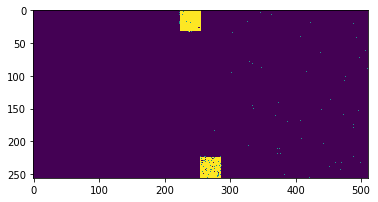

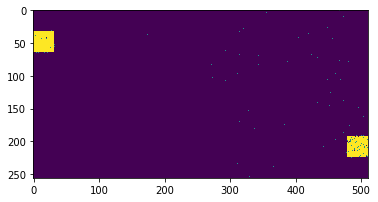

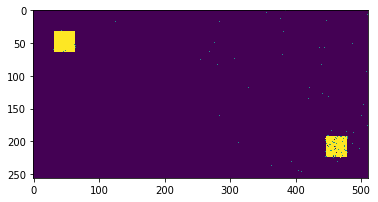

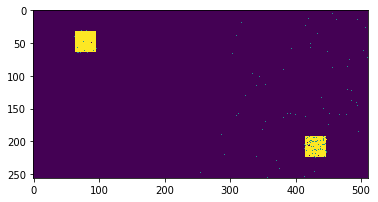

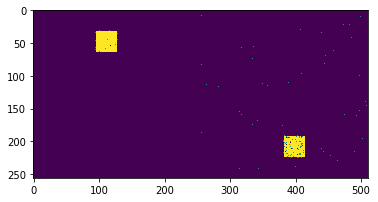

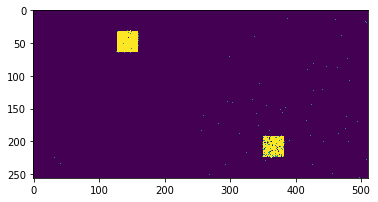

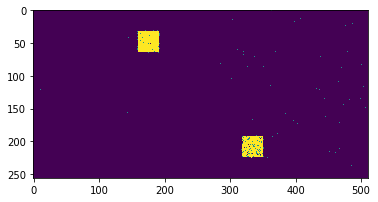

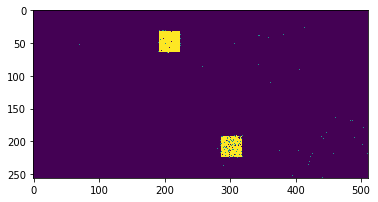

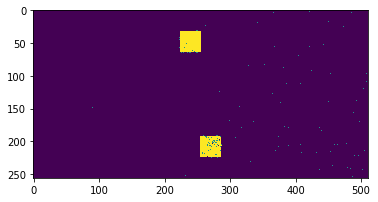

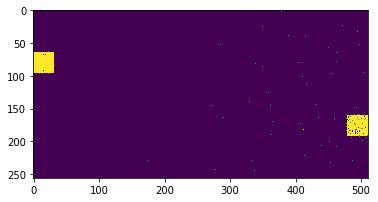

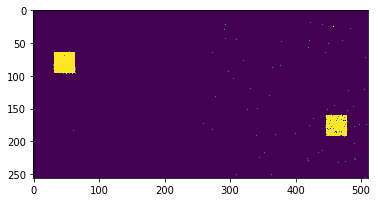

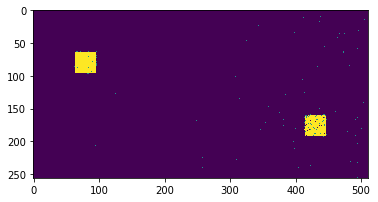

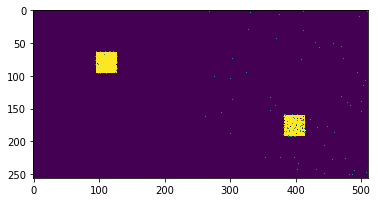

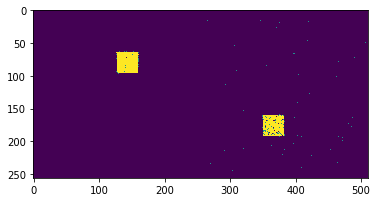

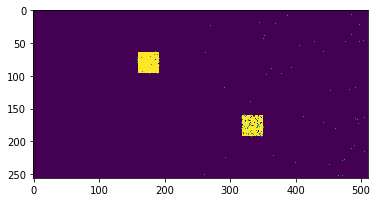

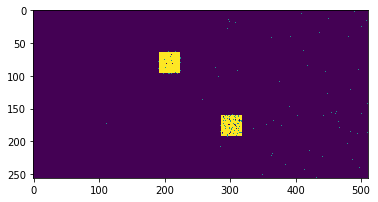

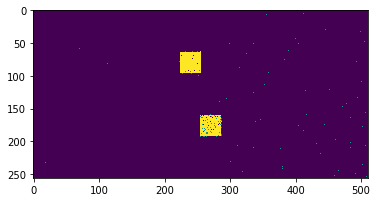

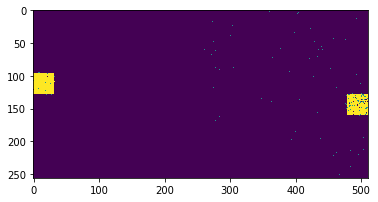

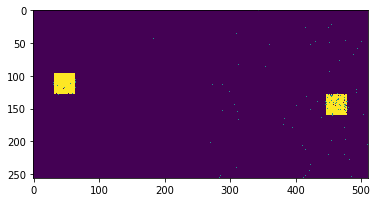

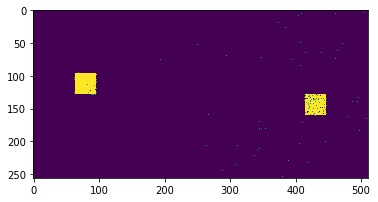

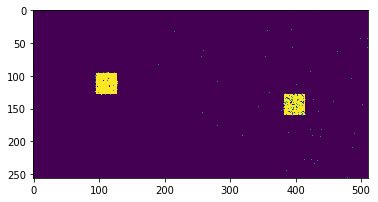

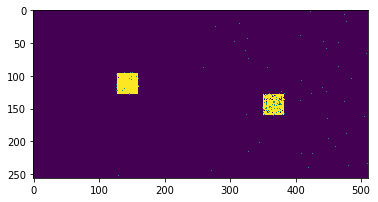

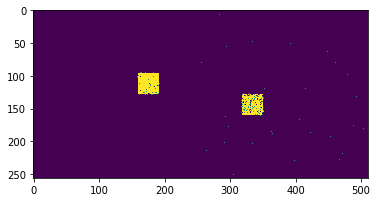

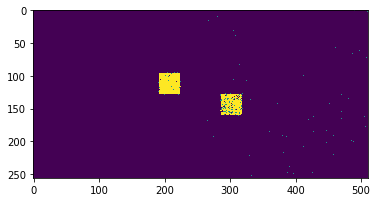

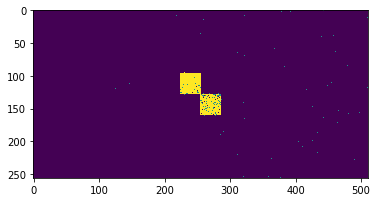

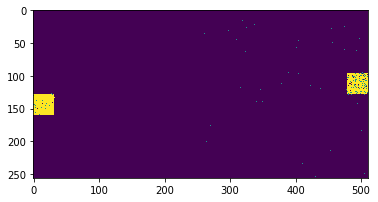

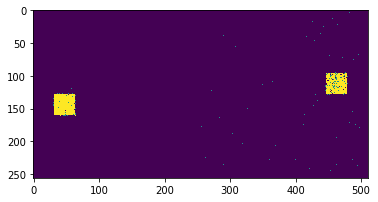

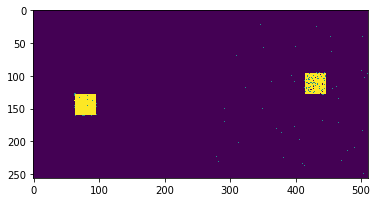

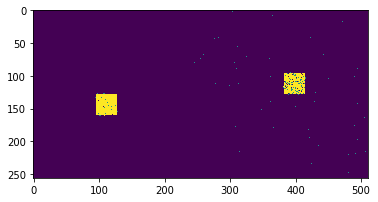

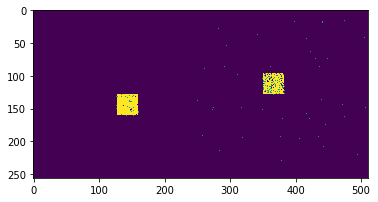

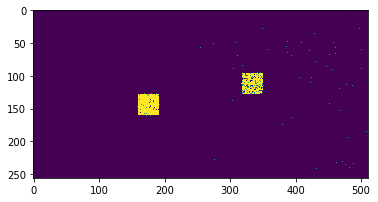

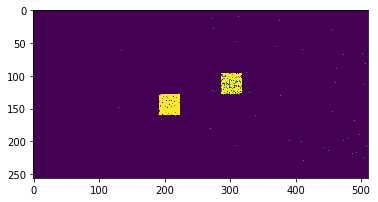

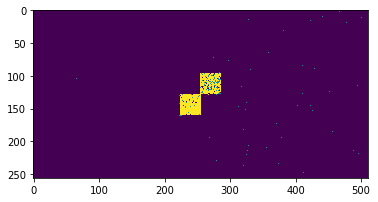

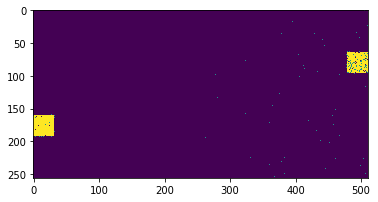

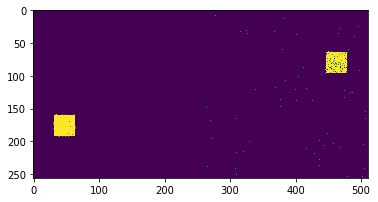

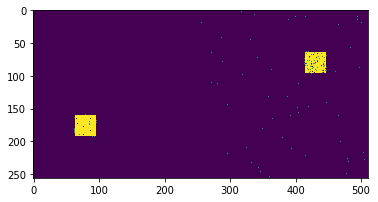

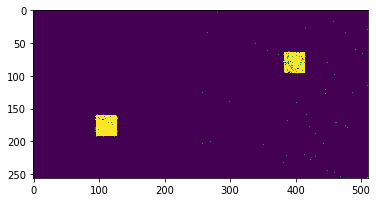

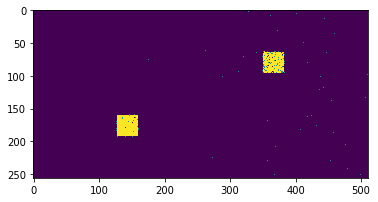

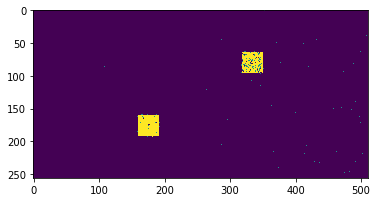

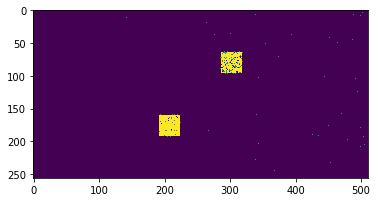

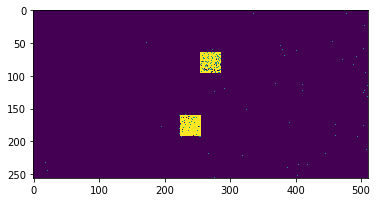

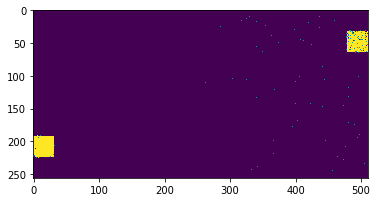

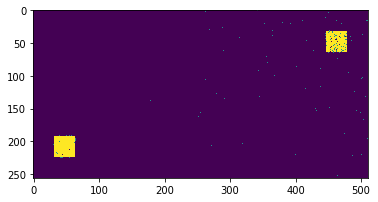

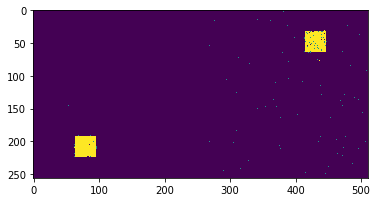

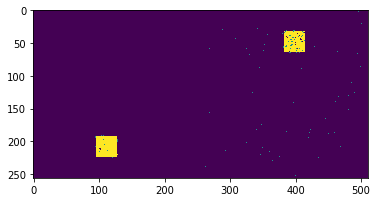

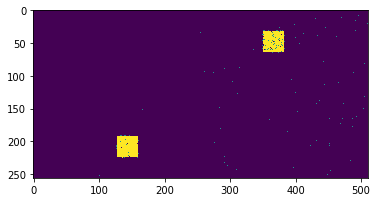

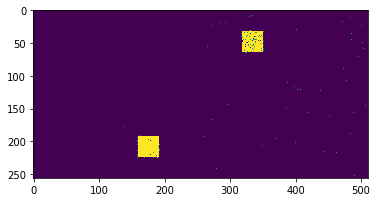

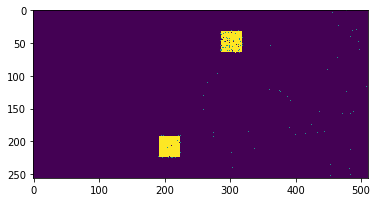

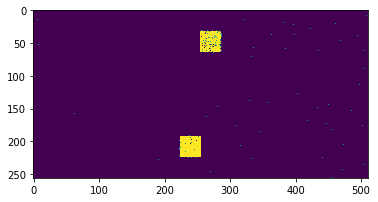

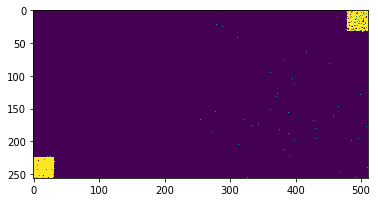

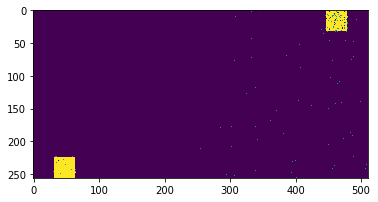

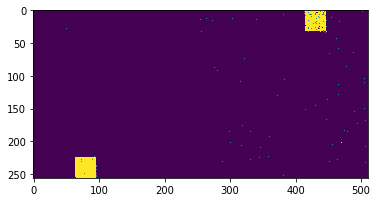

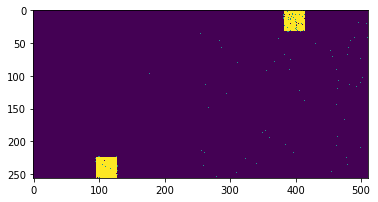

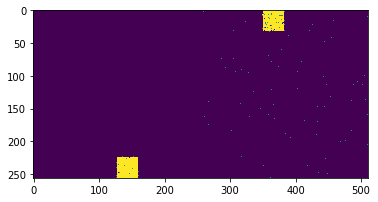

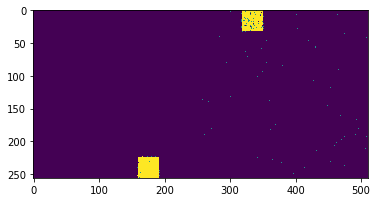

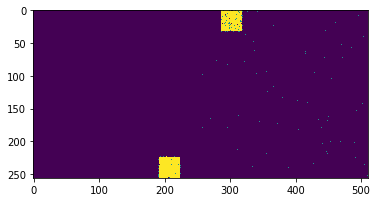

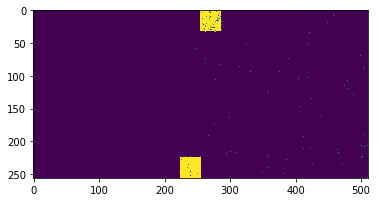

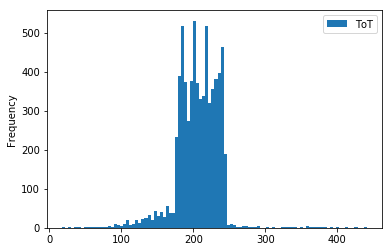

In [7]:
#analyse coincidence data from h5 
#### run first cell first
print tt
store = pd.HDFStore(datapath+'/'+dataset+'.h5')
all_coinc=store['all_coinc']; #load it back
isize=max(all_coinc.I+1)
jsize=max(all_coinc.J+1)


######### remove plotting for now....

#filter
roilist=sequential_roi_list(256,256,8,8)
print tt
for roi in roilist:
    #roi=roilist[36] #single roi in middle
    #time only
    #coinc=all_coinc[(all_coinc.I>=roi[0][0]) & (all_coinc.I<=roi[0][1]) & (all_coinc.J>=roi[1][0]) & (all_coinc.J<=roi[1][1]) ]
    #time and energy
    coinc=all_coinc[(all_coinc.I>=roi[0][0]) & (all_coinc.I<=roi[0][1]) & (all_coinc.J>=roi[1][0]) 
        & (all_coinc.J<=roi[1][1]) &  (all_coinc.ToT+all_coinc.ToT0>350)  & (all_coinc.ToT+all_coinc.ToT0<490)]
    #create image
    im_coinc=mk_image1(coinc, isize, jsize)
    plt.figure(); plt.imshow(im_coinc, vmax=2)
print tt
#coin.plot(y='ToT',kind='hist',bins=1+2*coinc_range, title='Pair No. '+str(filepairnum) ) #will crash if no coincidences
coinc.plot(y='ToT',kind='hist', bins=100)

In [15]:
store = pd.HDFStore(datapath+'/'+dataset+'.h5')
all_coinc=store['all_coinc']; #load it back

<IPython.core.display.Javascript object>


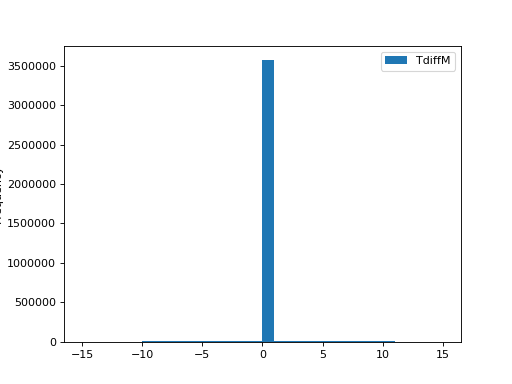

In [16]:
all_coinc.plot(y='TdiffM',kind='hist',bins=range(-15,16))

<IPython.core.display.Javascript object>


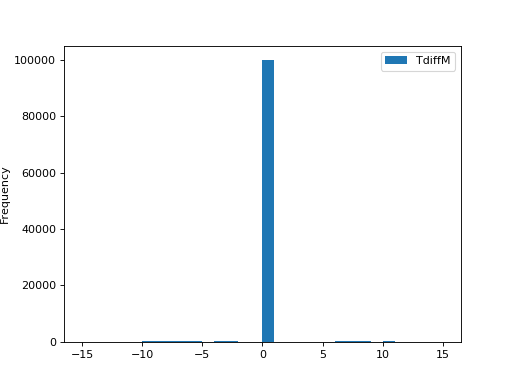

In [17]:
#filter on energy sum
all_coinc['en_tot'] = all_coinc.ToT + all_coinc.ToT0
en_filtered=all_coinc[(all_coinc.en_tot >= 615) & (all_coinc.en_tot <= 875)]
len(en_filtered)
en_filtered.plot(y='TdiffM',kind='hist',bins=range(-15,16))


In [11]:
all_coinc

,I,J,ToA,ToT,Module,Tdiff,Mdiff,TdiffM,Prev_coinc,Next_coinc,I0,J0,ToA0,ToT0,Module0,en_tot
187,56,42,2222315559,51,0,10,-1,-10,0,1,140,280,2222315549,813,1,864
232,63,85,2222499142,420,0,2,-1,-2,1,1,196,320,2222499140,214,1,634
336,127,176,2222942226,1000,0,1,-1,-1,0,0,64,468,2222942225,793,1,1793
609,26,244,2223983746,680,0,4,-1,-4,1,0,162,257,2223983742,204,1,884
827,68,170,2225020175,843,0,5,-1,-5,0,1,96,386,2225020170,752,1,1595
967,14,72,2225656798,636,0,5,-1,-5,0,1,250,383,2225656793,689,1,1325
1146,27,79,2226395600,730,0,0,-1,0,1,1,113,352,2226395600,314,1,1044
1147,28,79,2226395604,166,0,2,-1,-2,1,1,112,353,2226395602,232,1,398
1358,118,162,2227214433,857,0,5,-1,-5,0,0,126,502,2227214428,862,1,1719
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [12]:
#plot data at beam lost (sorted data)
%matplotlib notebook
top_last=pd.read_csv(datapath+'/20161212_I16_W2J2_TOP_Decoded_Sorted/long5_2016-12-12-17-38-24.130648_decoded_Sorted.dat', sep='\t', usecols=[0,1,2,3], names=['I','J','ToA','ToT'])
bot_last=pd.read_csv(datapath+'/20161212_I16_W5I6_BOT_Decoded_Sorted/long5_2016-12-12-17-41-18.745739_decoded_Sorted.dat', sep='\t', usecols=[0,1,2,3], names=['I','J','ToA','ToT'])
figure(); plot(top_last.ToA, top_last.ToT); plot(bot_last.ToA, bot_last.ToT)


IOError: File /dls/i16/data/2017/mt16227-1/processing/5_5_2017//20161212_I16_W2J2_TOP_Decoded_Sorted/long5_2016-12-12-17-38-24.130648_decoded_Sorted.dat does not exist

In [ ]:
top_last